Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2613 - Inteligencia Artificial
<br>

<center>
    <h2> Ayudantía 9 </h2>
    <h1> SVM: Support-vector machine </h1>
    <p>
        Andrés Catalán: acataf@uc.cl  <br> 
        Ignacio Villanueva: ignacio.villanueva@uc.cl<br>
        2022 - 1    
    </p>
    <br>
    <img src="https://miro.medium.com/max/1200/1*FGzasG-84SHk_XXSClcoqA.png" width="600"/>
</center>

<br>

---

# Binary Classifier SVM

In [13]:
!pip -q install celluloid
# Creamos el dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from celluloid import Camera
from IPython.core.display import Video
import celluloid


# Definimos una clase con la implementación de SVM binario
class BinaryClassifierSVM:
    
    # El modelo tiene por defecto el valor de los parametros del hiperplano y C.
    def __init__(self, C=1):
        self.C = C
        self.params = np.array([-1, 1, 1]).astype(float)
    
    # Esta función retornará cuán mal se ajusta nuestra hipótesis actual a los datos
    def funcion_costo(self, X, Y):
        norm = (self.params**2).sum()       #--> (||w||^2)       # 1. Norma de los parámetros (||B||) 
        dist = 1 - Y*np.dot(X,self.params) #--> 1 - y*(x.w)  # 2. A cuánto estamos actualmente dentro del margen máximo para cada punto!
        dist = dist[dist>0]                # Restriccion      # Sólo nos importa las distancias que son mayores a cero,
                                        # porque eso podría significar:
                                        # a) Esta bien clasificada, pero el margen es menor a 1 --> (0 < 1 - Y * <X,w> < 1).
                                        # b) Esta mal clasificado (Y*<x, w> < 0)
        return norm/2, self.C*dist.sum(), norm/2+self.C*dist.sum()
    
    # Esta función calcula el gradiente de nuestra función de costo con respecto a 
    # nuestros parámetros
    def calcular_gradiente(self, X, Y):
        """
        valid_sample es una matriz en donde las columnas indican si el valor es mayor a 0 (1 en la matriz) o no (0 en la matriz),
        de esta forma en la sumatoria solo se consideraran los samples validos (con 1's en la matriz)
        1er valid_sample: Toma las distancias mayores a cero en forma de array de n columnas
        2do valid_sample(expand_dims): convierte las n columnas en n filas y 1 columna
        3er valid_sample(repeat): repite la primera columna 3 veces creando una matriz de n filas y 3 columnas

        --> Luego hace lo mismo con el vector Y, lo pasa de n columnas y 1 fila a 1 columna y n filas luego a 3 columnas y n filas.
        """
        grad_margin = self.params
        dist = 1 - Y*np.dot(X,self.params) # Calculamos la distacia entre los puntos y e hiperplano
        valid_sample = (dist>0).astype(float) # Sólo consideramos los datos que están dentro del margen o mal clasificados
        valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
        Y = np.expand_dims(Y,axis=1).repeat(3,axis=1)
        grad_clas = -valid_sample*Y*X 

        return grad_margin+self.C*grad_clas.sum(axis=0) # Retornamos el gradiente como la fórmula de arriba
    
    def train(self, X_train, y_train):
        iterations = 50         # Número de iteraciones que tomaremos
        delta = 0.005           # Tamaño de los pasos para cada iteración del Descenso de Gradiente
        
        # Sólo para visualización!! Condiciones iniciales
        self.hyperplane_plot(X_train, y_train, 0, init_conditions=True)
        ##############################################
        
        # Train our SVM
        for iteration in range(1,iterations+1):

            # Calculamos el gradiente!
            grad = self.calcular_gradiente(X_train, y_train)
            # paso en Descenso de Gradiente!
            self.params -= delta*grad

            # Actualizamos desempeño de métricas
            norma, dist, total = self.funcion_costo(X_train, y_train)

            # Sólo para visualización!! Nuevo hiperplano
            self.hyperplane_plot(X_train, y_train, iteration)
        # Creamos animación final
        self.generate_animation()
        
    # Sólo para visualización
    def hyperplane_plot(self, X_train, y_train, iteration, init_conditions=False):
        if init_conditions:
            self.x_line = np.arange(-3,5,0.1)
            fig, self.ax = plt.subplots()
            self.ax.set_ylim([-7, 7])
            self.camera = Camera(fig)
        size = len(X_train) // 2
        line = [-(self.params[-1] + x*self.params[0])/self.params[1] for x in self.x_line]
        self.ax.text(0.5, 1.01, f"Iteración: {iteration} - Costo :{self.funcion_costo(X_train, y_train)[-1]:.2f}", transform=self.ax.transAxes)
        plt.scatter([x[0] for x in X_train[:size]],[x[1] for x in X_train[:size]],color="red")
        plt.scatter([x[0] for x in X_train[size:]],[x[1] for x in X_train[size:]],color="blue")
        plt.plot(self.x_line, line, color = "green")
        self.camera.snap()
    
    # Sólo para visualización
    def generate_animation(self):
        anim = self.camera.animate(blit=True)
        writergif = animation.PillowWriter(fps=30)
        anim.save('result.gif',writer=writergif)
        Video("result.gif", embed=True)
    
    def accuracy(self, X_test, y_test):
        # Calculamos predicciones para nuestro modelo
        preds = np.dot(X_test, self.params) > 0 # Calculamos distancia para cada dato y verificamos su clasificación
        correct = preds == (np.array(y_test) > 0) # Sólo tomamos los datos bien clasificados
        accuracy = correct.astype(int).sum()/correct.shape[0]  
        return 100 * accuracy

In [5]:
size = 100
train_data = []
test_data = []
labels = [-1 for i in range(size)] # Clase negativa
labels += [1 for i in range(size)] # Clase positiva

# Queremos predecir puntos tomados de una distribución normal
mu = [[0,0], [3.0,3.0]]                  # Medias
std = [[[1,0],[0,1]],[[1/3,0], [0,1/3]]] # Matriz de covarianza

# Creamos el set de train
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(2*size) ]

# Creamos el set de test
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(2*size) ]

# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
plt.title("Visualization of Training Data")
plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
plt.show()

[array([ 1.78071665, -0.16849847]), array([ 0.00170867, -0.37566651]), array([0.3065334 , 0.26068236]), array([-1.16755653,  0.54012751]), array([-1.48989708,  0.34284798]), array([2.51343294, 0.66738051]), array([0.07126614, 0.78896359]), array([-0.49293515, -0.57823326]), array([-2.35632772,  1.44106704]), array([ 1.04950505, -1.02253407]), array([-0.46404394, -1.08375628]), array([-1.11481164,  0.95314533]), array([-0.50358365,  0.37101324]), array([-0.40878208, -2.5052241 ]), array([-0.71675628,  0.32798158]), array([-1.88817793,  0.15706038]), array([1.09129146, 0.84968296]), array([-1.53903225, -0.8945548 ]), array([-1.74748595, -0.33164184]), array([-0.15272569, -1.53177523]), array([-1.16069825,  0.01534534]), array([-0.3452196 , -0.79377219]), array([-0.9123373 ,  1.04301551]), array([ 0.08032445, -0.58102519]), array([0.98153376, 0.35769309]), array([-0.97997754,  1.24390599]), array([0.07961164, 0.16349607]), array([-0.66305698, -0.47237329]), array([ 0.70848575, -0.42260787

NameError: ignored

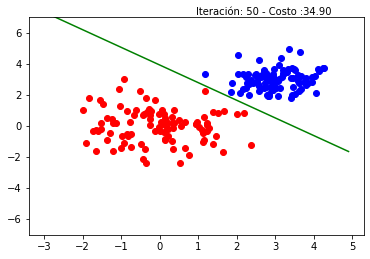

In [22]:
# Instanciamos nuestro modelo con los datos generados
SVM_binary_classifier = BinaryClassifierSVM(C=10)

# Entrenamos el modelo..
SVM_binary_classifier.train(train_data, labels)

Training Accuracy: 100.0%
Test Accuracy: 100.0%


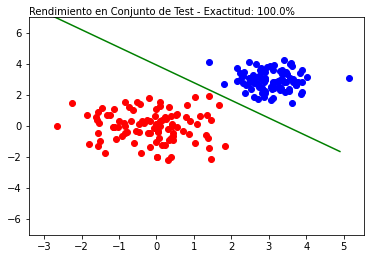

In [24]:
# Accuracy para train y test.
train_accuracy = SVM_binary_classifier.accuracy(train_data, labels)
print(f"Training Accuracy: {train_accuracy}%")

test_accuracy = SVM_binary_classifier.accuracy(test_data, labels)
print(f"Test Accuracy: {test_accuracy}%")

# Visualización del hiperplano en el set de test
x_line = np.arange(-3,5,0.1)
line = [-(SVM_binary_classifier.params[-1] + x*SVM_binary_classifier.params[0])/SVM_binary_classifier.params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.0, 1.01, f"Rendimiento en Conjunto de Test - Exactitud: {test_accuracy}%", transform=ax.transAxes)
ax.set_ylim([-7, 7])
plt.scatter([x[0] for x in test_data[:size]],[x[1] for x in test_data[:size]],color="red")
plt.scatter([x[0] for x in test_data[size:]],[x[1] for x in test_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
plt.show()

# SVM Multiclase

Se puede hacer con Sepal tambien.

Dataset: https://www.kaggle.com/datasets/uciml/iris

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
import pandas as pd

iris_ds = pd.read_csv("/tmp/Iris.csv")
iris_ds = iris_ds[["PetalLengthCm", "PetalWidthCm", "Species"]]

for i in range(len(iris_ds["Species"])):
  if iris_ds["Species"][i] == "Iris-setosa":
    iris_ds["Species"][i] = 0

  elif iris_ds["Species"][i] == "Iris-versicolor":
    iris_ds["Species"][i] = 1
    
  elif iris_ds["Species"][i] == "Iris-virginica":
    iris_ds["Species"][i] = 2

iris_ds.dropna()
iris_ds.Species = iris_ds.Species.astype("int64")
iris_ds.head()
iris_ds.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PetalLengthCm  150 non-null    float64
 1   PetalWidthCm   150 non-null    float64
 2   Species        150 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.6 KB


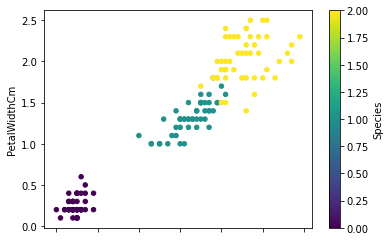

In [82]:
graph = iris_ds.plot.scatter(x='PetalLengthCm',
                    y='PetalWidthCm',
                    c='Species',
                    colormap='viridis')

In [83]:
from sklearn.model_selection import train_test_split

X = iris_ds[["PetalLengthCm", "PetalWidthCm"]]
y = iris_ds["Species"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1010)
X_train.shape, X_test.shape

((120, 2), (30, 2))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


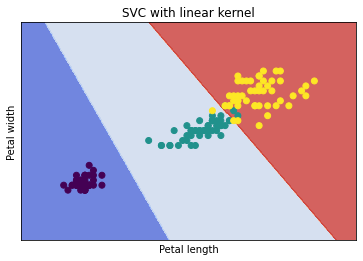

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  "X does not have valid feature names, but"


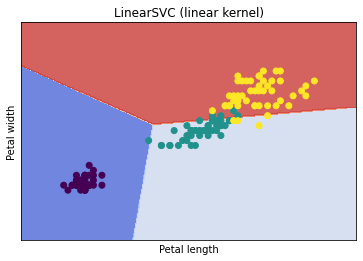

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


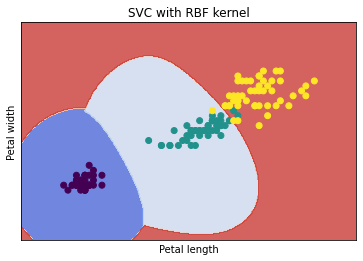

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


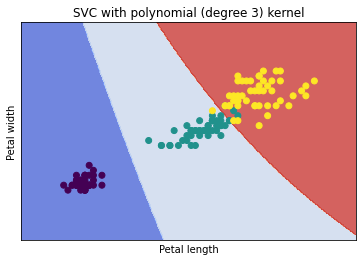

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X_train, y_train)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X_train, y_train)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X_train, y_train)
lin_svc = svm.LinearSVC(C=C).fit(X_train, y_train)

# create a mesh to plot in
x_min, x_max = X_train["PetalLengthCm"].min() - 1, X_train["PetalLengthCm"].max() + 1
y_min, y_max = X_train["PetalWidthCm"].min() - 1, X_train["PetalWidthCm"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with Custom Kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc,)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    # plt.subplot(2, 2, i + 1)
    # plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X["PetalLengthCm"], X["PetalWidthCm"], c=y, cmap=plt.cm.viridis)
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.show()

# plt.show()

In [73]:
def my_kernel(X, Y):
    M = np.array([[1, 2], [3, 4]])
    return np.dot(np.dot(X, M), Y.T)

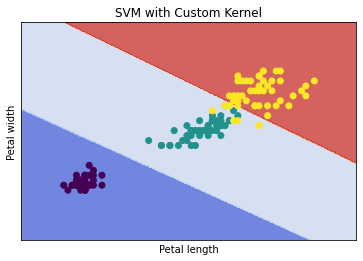

In [74]:
myKernel_svc = svm.SVC(kernel=my_kernel, C=C).fit(X_train, y_train)

# create a mesh to plot in
x_min, x_max = X_train["PetalLengthCm"].min() - 1, X_train["PetalLengthCm"].max() + 1
y_min, y_max = X_train["PetalWidthCm"].min() - 1, X_train["PetalWidthCm"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = myKernel_svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X["PetalLengthCm"], X["PetalWidthCm"], c=y, cmap=plt.cm.viridis)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("SVM with Custom Kernel")

plt.show()


# Datos No Lineales

25 25
25


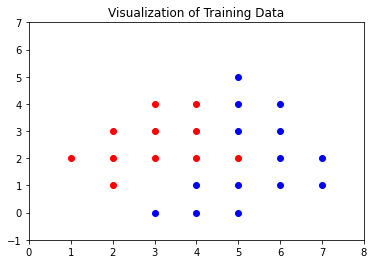

In [78]:
import numpy as np

X = []
train_data = [[1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, 5, 5], [2, 2, 1, 3, 2, 3, 4, 2, 3, 4, 2, 3, 0, 0, 1, 1, 0, 1, 2, 3, 4, 1, 2, 4, 5]]
print(len(train_data[0]), len(train_data[1]))
for i in range(len(train_data[0])):
  X.append([train_data[0][i], train_data[1][i]])

y = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
print(len(y))

X = np.array(X)
X_1 = np.c_[X, np.ones(25)]

# Graficamos condiciones iniciales!
fig, ax = plt.subplots()
ax.set_ylim([-1, 7])
ax.set_xlim([0, 8])
plt.title("Visualization of Training Data")
plt.scatter([x[0] for x in X_1[:11]],[x[1] for x in X_1[:11]],color="red")
plt.scatter([x[0] for x in X_1[11:]],[x[1] for x in X_1[11:]],color="blue")
plt.show()

In [79]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

No handles with labels found to put in legend.


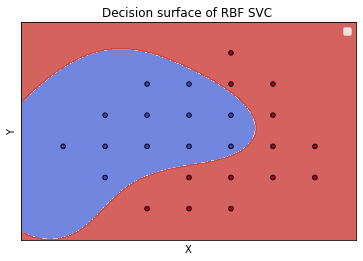

In [80]:
model = svm.SVC(kernel='rbf', C = 10)
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of RBF SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

No handles with labels found to put in legend.


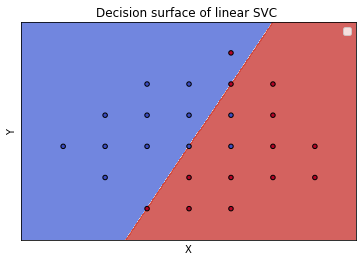

In [81]:
model = svm.SVC(kernel='linear', C = 10)
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

No handles with labels found to put in legend.


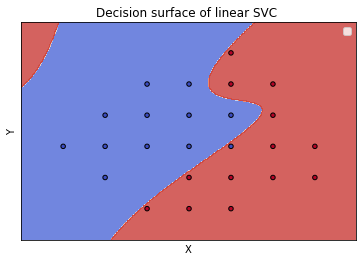

In [56]:
model = svm.SVC(kernel='poly', degree = 5, C = 10)
clf = model.fit(X, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()